In [1]:
"""
(*)~---------------------------------------------------------------------------
author: p.wagner@unsw.edu.au / p.wagner@bhvi.org

Calculates mean average error [MAE] from summarized PLPF data. 
Part 1: 
draw diagram MAE for px / initial, 5 min, 1 hour 

dependencies:
    - experiment_execution_logV.2.xlsx', sheet_name='master'
    - manual entry of accuracy data  

Part 2: 
extracting accuracy data using meta data from each recording
dependency: 
    - 't_pos_gaze_coordinates_meta.csv' of each recording
---------------------------------------------------------------------------~(*)
"""
import pandas as pd
import numpy as np 
import os, math
import matplotlib.pyplot as plt
%matplotlib inline
import GDDA_library as GDDA
from scipy import stats


C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:11: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  # This is added back by InteractiveShellApp.init_path()


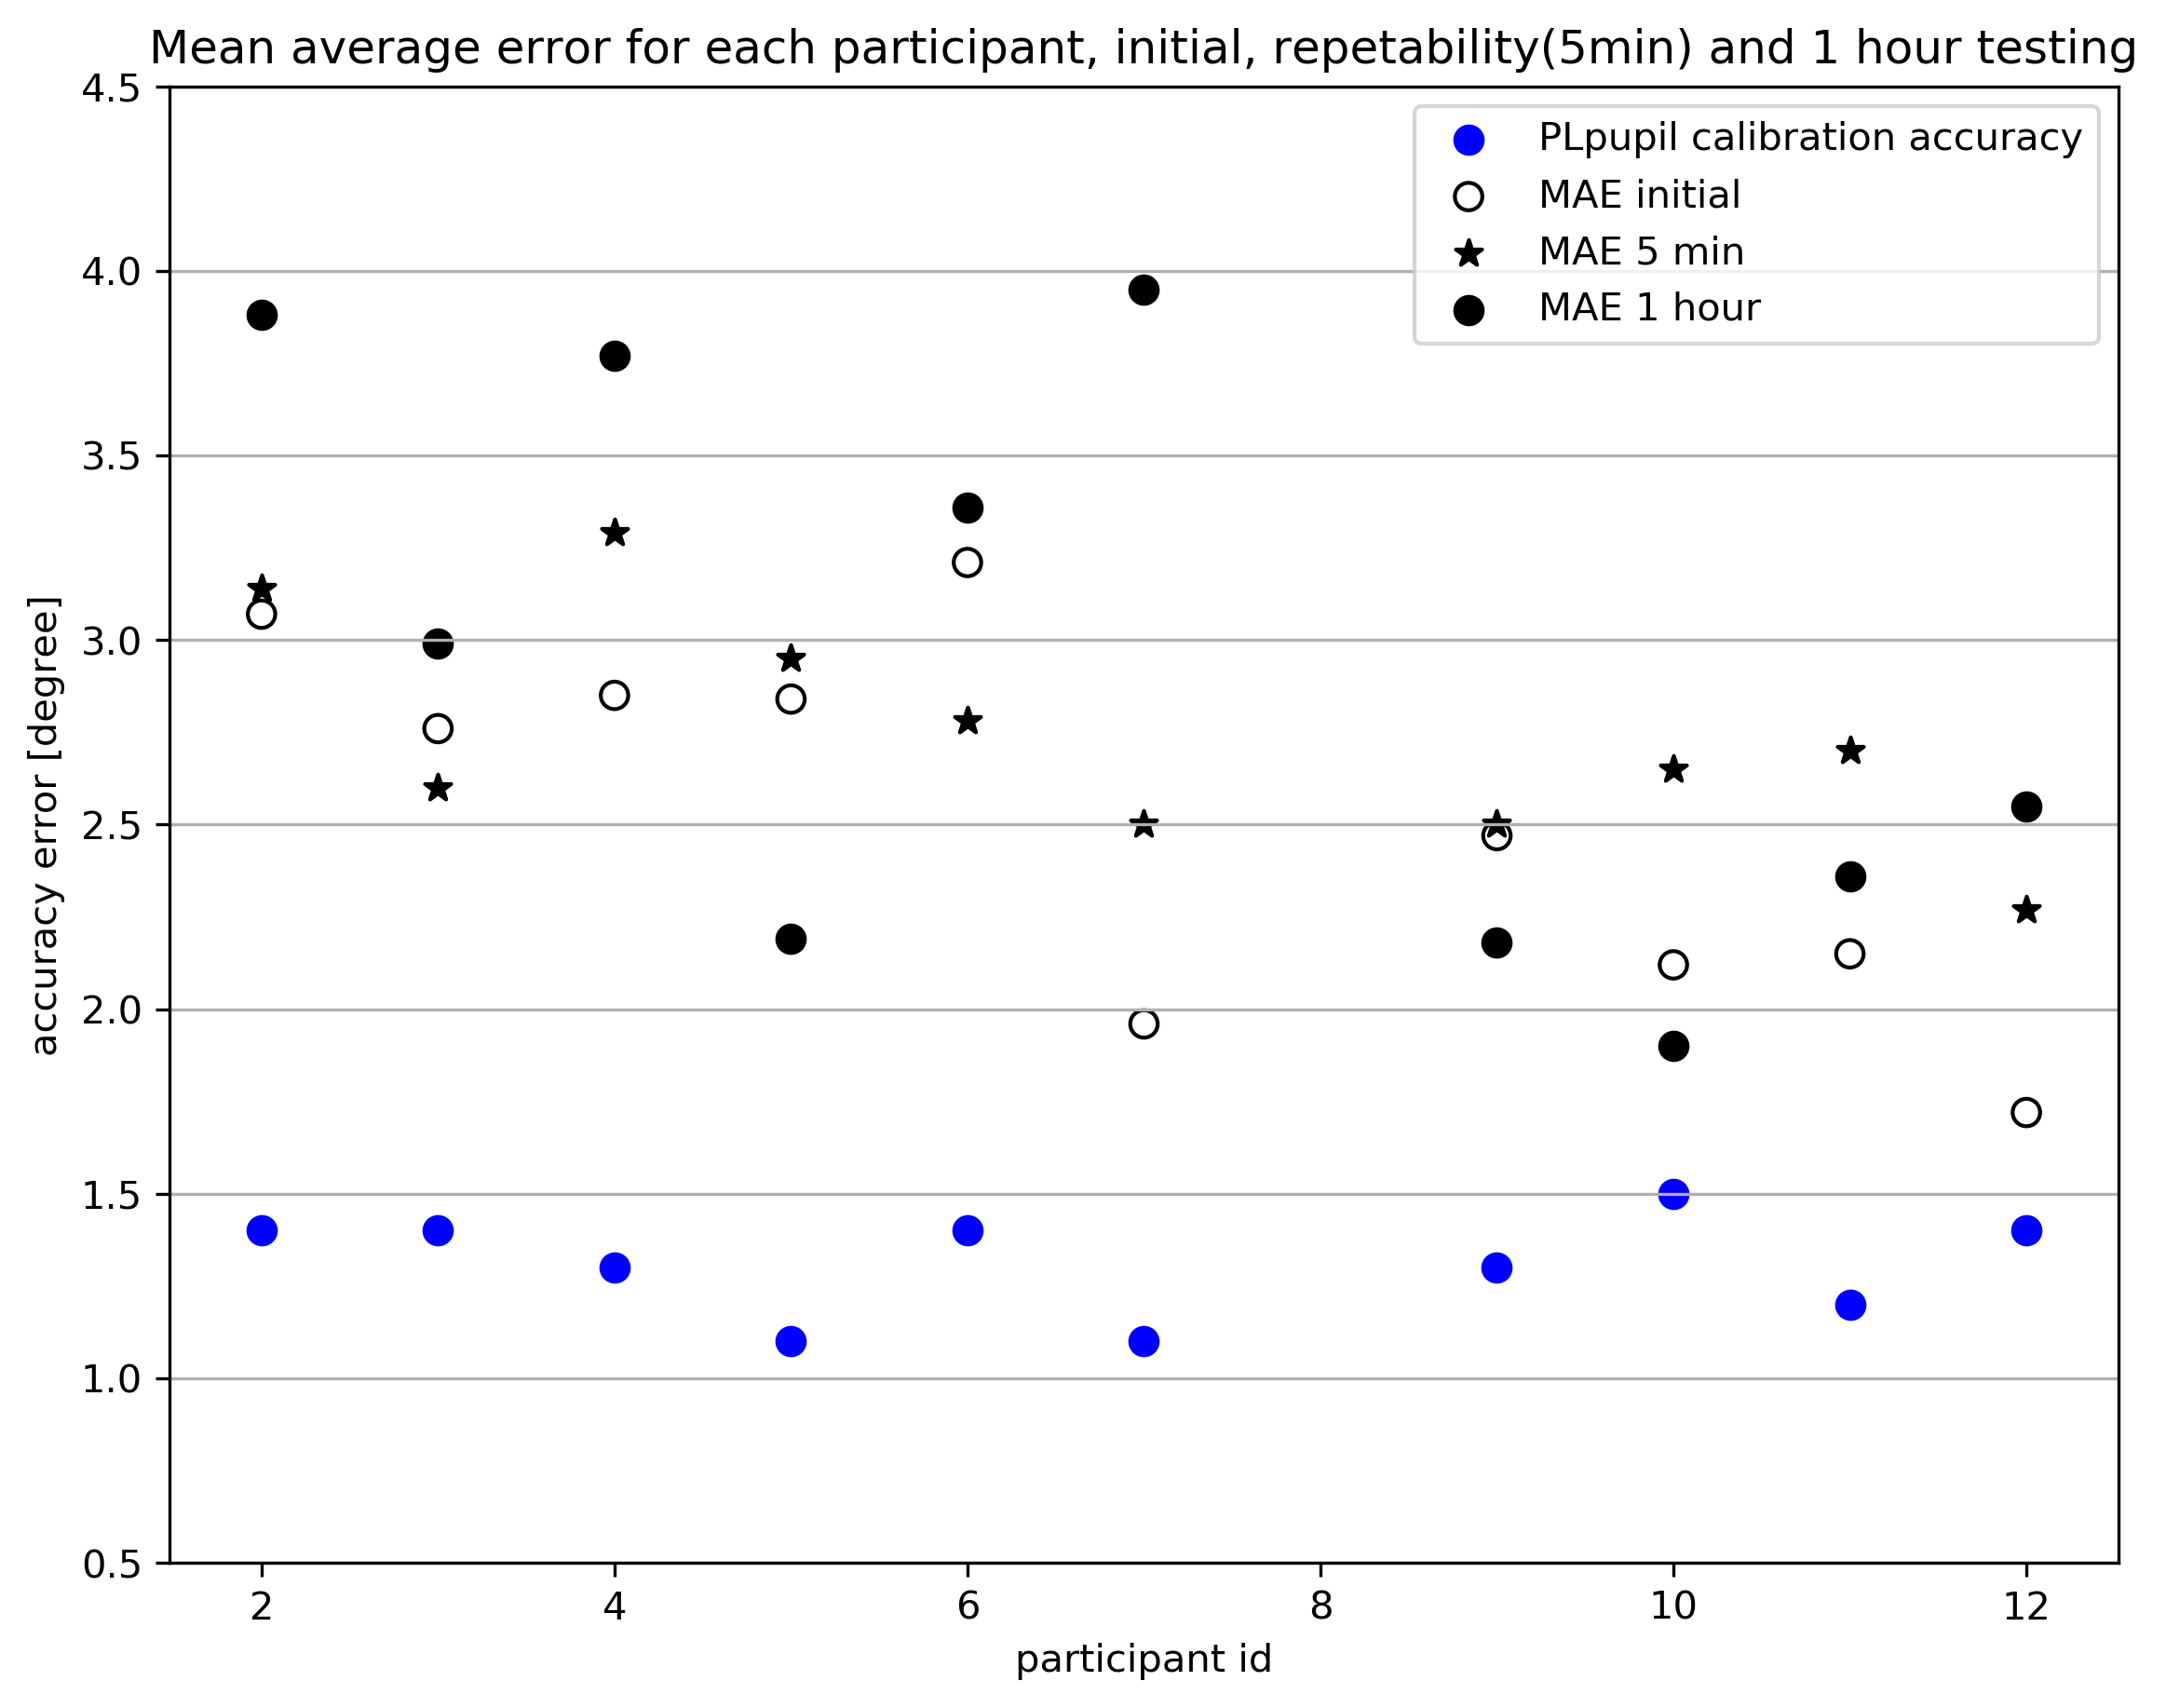

In [2]:
# Part 1 
# # # Visualise manual data from Video frame matching of eye-tracking and world camera. 
# recordings_fp = r'C:\Users\p.wagner\recordings\2020_06_26'
participant_IDs = [2, 3, 4, 5, 6, 7, 9, 10, 11, 12] 
# read df and select data, participant_IDs only 
df = pd.read_excel (r'C:\Users\p.wagner\Documents\experiment_execution_logV.2.xlsx', 
                   sheet_name='master', 
                   index_col = 0)
df = df.iloc[29:42, 7:28]
df = df.loc[:, participant_IDs]
df = df.T

fig = plt.figure(figsize=(9, 7), dpi=300, facecolor='w', edgecolor='k')
plt.scatter(df.index, df.loc[:, 'accuracy'], s= 50, c = 'blue',  marker='o', label='PLpupil calibration accuracy') 
plt.scatter(df.index, df.loc[:,'MAE initial'], s= 50, color ='none', marker='o', edgecolors= 'k', label='MAE initial' )
plt.scatter(df.index, df.loc[:,'MAE 5 min'], s= 50, color ='k', marker='*', label='MAE 5 min')
plt.scatter(df.index, df.loc[:,'MAE 1 hour'],  s= 50, color ='k', marker = 'o', label='MAE 1 hour')
plt.legend() 
plt.title('Mean average error for each participant, initial, repetability(5min) and 1 hour testing')
plt.xlabel('participant id')
plt.ylabel('accuracy error [degree]')
plt.ylim([0.5, 4.5])
ax = plt.axes()        
ax.yaxis.grid()

output_fn = os.path.join(r'C:\Users\p.wagner\Documents\phd\output', 
                         'MAE_px_init_5m_1h.jpeg')

plt.savefig(output_fn, orientation='landscape')


In [5]:
# Part 2: 
# extracting accuracy data using meta data from each recording
participant_IDs = [2, 3, 4, 5, 6, 7, 9, 10, 11, 12] 
recordings_location = r'D:\PupilLabsRecordings'
accs_rec_ids = ['acc_rec_initial', 'acc_rec_5min', 'acc_rec_1hour']

participant_logbook = pd.read_excel(r'C:\Users\p.wagner\Documents\experiment_execution_logV.2.xlsx', index_col=0 )
acc_rec_fps_all = pd.DataFrame(columns=['px_id', 'acc_id', 'acc_rec_fp'])

for participant_ID in participant_IDs:
    acc_rec_fps = GDDA.get_acc_rec_fps(participant_logbook, participant_ID, recordings_location, accs_rec_ids)
    acc_rec_fps_all = acc_rec_fps_all.append(acc_rec_fps, ignore_index=True)

# set px number to extract data 
px = 5

MAE = pd.DataFrame(columns= ['px_id', 'high_confi_n', 'acc_id', 'x', 'y', 't_id' ])
for t_aimed in range(1,12):
    for idx, recording_fp in enumerate(acc_rec_fps_all.loc[:, 'acc_rec_fp']):
        # # load t_pos_gaze_coordinates_meta.csv 
        if not os.path.isfile(os.path.join(recording_fp, 't_pos_gaze_coordinates_meta.csv')): 
            sys.exit("Source files missing t_pos_gaze_coordinates_meta.csv")  
        ttd_meta_data = pd.read_csv(os.path.join(recording_fp, 't_pos_gaze_coordinates_meta.csv'), index_col = 0)
        
        MAE_new = pd.DataFrame(columns= ['px_id', 'high_confi_n', 'acc_id', 'x', 'y', 't_id' ])
        MAE_new.loc[0, 'px_id']= acc_rec_fps_all.loc[idx, 'px_id']
        MAE_new.loc[0, 'high_confi_n']= ttd_meta_data.loc[t_aimed, 'gaze_per_t_high_confi']
        MAE_new.loc[0, 'acc_id']= acc_rec_fps_all.loc[idx, 'acc_id']
        MAE_new.loc[0, 'x'] = (((ttd_meta_data.loc[t_aimed, 'x']-112) *.26)**2 + 
                               ((ttd_meta_data.loc[t_aimed, 'y']- 85) *.26)**2)**.5   
        MAE_new.loc[0, 'y'] = (ttd_meta_data.loc[t_aimed, 'delta_mean_cc_x']**2 + 
            ttd_meta_data.loc[t_aimed, 'delta_mean_cc_y']**2) **.5 *.26
        MAE_new.loc[0, 't_id'] = t_aimed
        MAE = MAE.append(MAE_new, ignore_index = True )


# MAE as in absolute vector lenth of gaze mean to actual target postion, weighted with high confi gaze per target
# # acc_rec_initial
print(sum(MAE.loc[(MAE.px_id == px) & (MAE.acc_id == 'acc_rec_initial'), 'y'] *\
              MAE.loc[(MAE.px_id == px) & (MAE.acc_id == 'acc_rec_initial'), 'high_confi_n'] ) / \
      sum(MAE.loc[(MAE.px_id == px) & (MAE.acc_id == 'acc_rec_initial'), 'high_confi_n'] ))  
print(sum(MAE.loc[(MAE.px_id == px) & (MAE.acc_id == 'acc_rec_initial'), 'high_confi_n'] ))
# # acc_rec_5min
print(sum(MAE.loc[(MAE.px_id == px) & (MAE.acc_id == 'acc_rec_5min'), 'y'] *\
              MAE.loc[(MAE.px_id == px) & (MAE.acc_id == 'acc_rec_5min'), 'high_confi_n'] ) / \
      sum(MAE.loc[(MAE.px_id == px) & (MAE.acc_id == 'acc_rec_5min'), 'high_confi_n'] ))
print(sum(MAE.loc[(MAE.px_id == px) & (MAE.acc_id == 'acc_rec_5min'), 'high_confi_n'] ))
# # acc_rec_1hour
print(sum(MAE.loc[(MAE.px_id == px) & (MAE.acc_id == 'acc_rec_1hour'), 'y'] *\
              MAE.loc[(MAE.px_id == px) & (MAE.acc_id == 'acc_rec_1hour'), 'high_confi_n'] ) / \
      sum(MAE.loc[(MAE.px_id == px) & (MAE.acc_id == 'acc_rec_1hour'), 'high_confi_n'] ))
print(sum(MAE.loc[(MAE.px_id == px) & (MAE.acc_id == 'acc_rec_1hour'), 'high_confi_n'] ))

2.840900987941448
1022.0
2.9459832258734364
1057.0
2.1897380478337922
1009.0


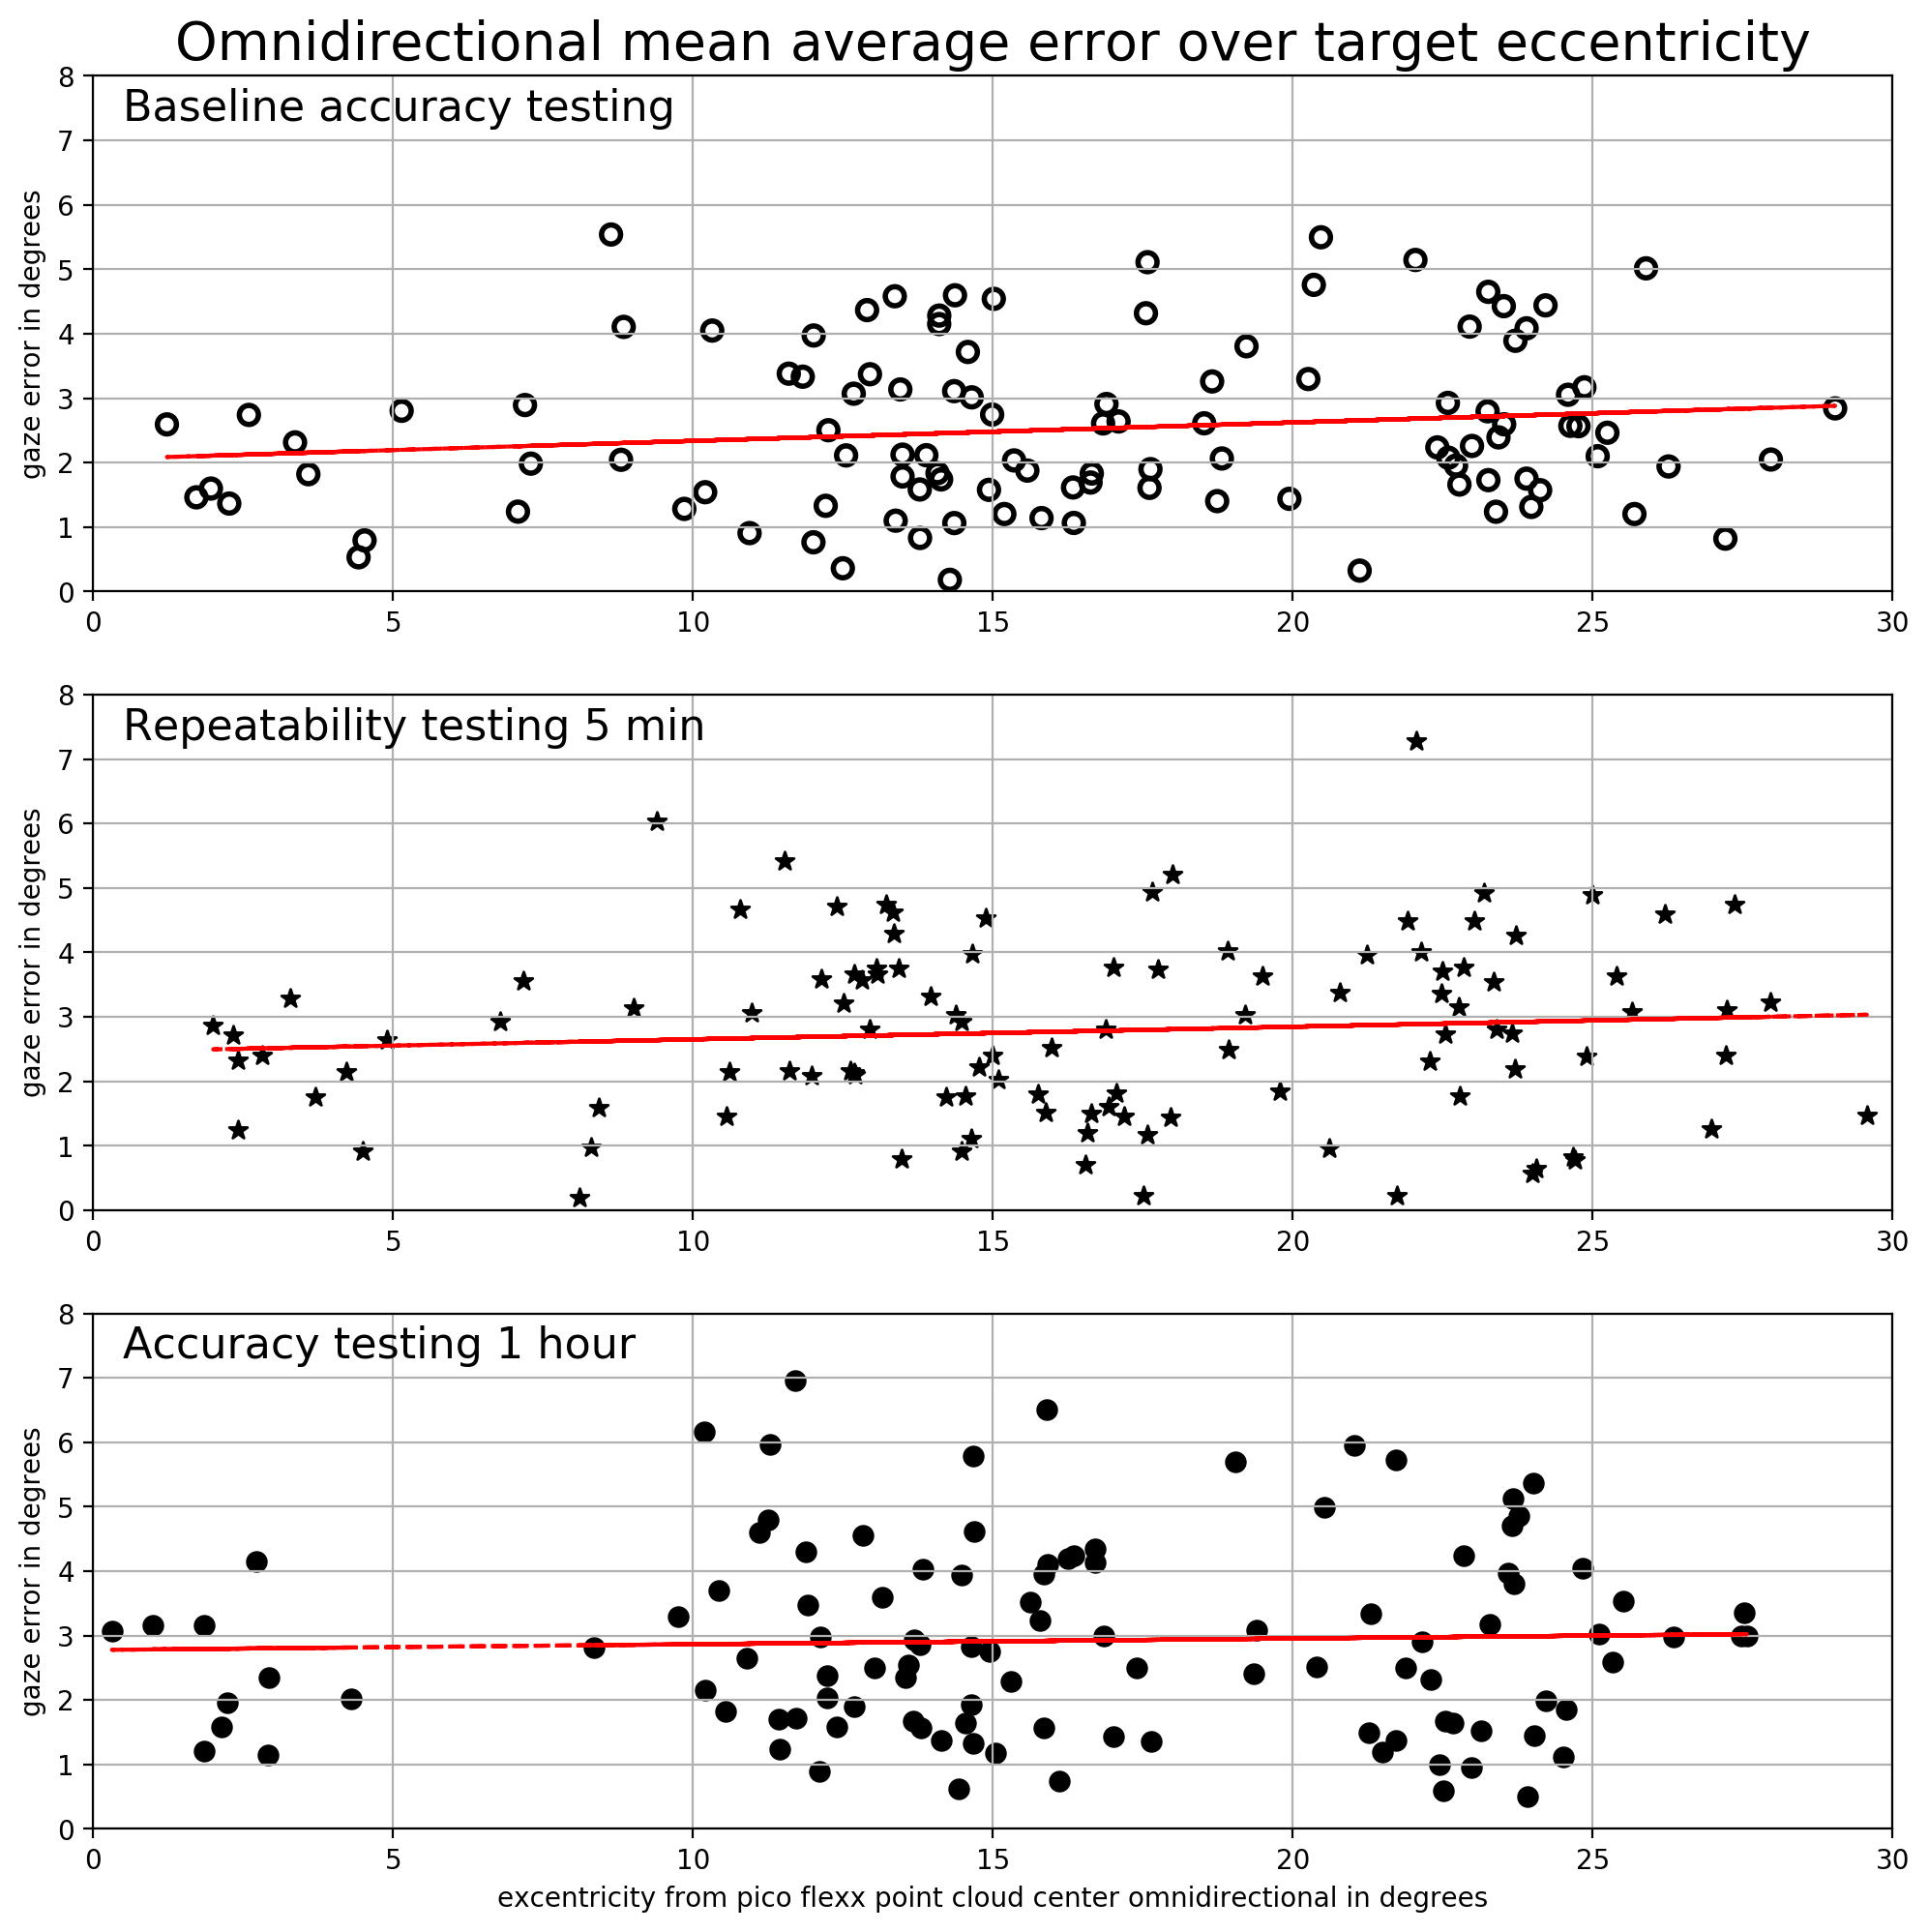

In [100]:
participant_IDs = [2, 3, 4, 5, 6, 7, 9, 10, 11, 12] 
recordings_location = r'D:\PupilLabsRecordings'
accs_rec_ids = ['acc_rec_initial', 'acc_rec_5min', 'acc_rec_1hour']


participant_logbook = pd.read_excel(r'C:\Users\p.wagner\Documents\experiment_execution_logV.2.xlsx', index_col=0 )
acc_rec_fps_all = pd.DataFrame(columns=['px_id', 'acc_id', 'acc_rec_fp'])

for participant_ID in participant_IDs:
    acc_rec_fps = GDDA.get_acc_rec_fps(participant_logbook, participant_ID, recordings_location, accs_rec_ids)
    acc_rec_fps_all = acc_rec_fps_all.append(acc_rec_fps, ignore_index=True)



MAE = pd.DataFrame(columns= ['px_id', 'high_confi_n', 'acc_id', 'x', 'y', 't_id', 'delta_mean_cc_x', 'delta_mean_cc_y' ])
for t_aimed in range(1,12):
    for idx, recording_fp in enumerate(acc_rec_fps_all.loc[:, 'acc_rec_fp']):
        ttd_meta_data = pd.read_csv(os.path.join(recording_fp, 't_pos_gaze_coordinates_meta.csv'), index_col = 0)
        
        MAE_new = pd.DataFrame(columns= ['px_id', 'high_confi_n', 'acc_id', 'x', 'y', 't_id', 
                                         'delta_mean_cc_x', 'delta_mean_cc_y' ])
        MAE_new.loc[0, 'px_id']= acc_rec_fps_all.loc[idx, 'px_id']
        MAE_new.loc[0, 'high_confi_n']= ttd_meta_data.loc[t_aimed, 'gaze_per_t_high_confi']
        MAE_new.loc[0, 'acc_id']= acc_rec_fps_all.loc[idx, 'acc_id']
        MAE_new.loc[0, 'x'] = (((ttd_meta_data.loc[t_aimed, 'x']-112) *.26)**2 + 
                               ((ttd_meta_data.loc[t_aimed, 'y']- 85) *.26)**2)**.5
        MAE_new.loc[0, 'delta_mean_cc_x'] = ttd_meta_data.loc[t_aimed, 'delta_mean_cc_x']
        MAE_new.loc[0, 'delta_mean_cc_y'] = ttd_meta_data.loc[t_aimed, 'delta_mean_cc_y']
        MAE_new.loc[0, 'y'] = (ttd_meta_data.loc[t_aimed, 'delta_mean_cc_x']**2 + 
            ttd_meta_data.loc[t_aimed, 'delta_mean_cc_y']**2) **.5 *.26
        MAE_new.loc[0, 't_id'] = t_aimed

        
        
        MAE = MAE.append(MAE_new, ignore_index = True )
        
        

fig, axs = plt.subplots(3, figsize=(12,12), dpi=200, facecolor='w', edgecolor='k' )
# INITIAL ACC TEST
axs[0].set_title('Omnidirectional mean average error over target eccentricity', fontsize=20)

axs[0].text(.5, 7.3, 'Baseline accuracy testing', fontsize=16)
marker_style = dict(marker='o', s=50, c ='none', edgecolor='k',linewidth=2)
x = MAE.loc[MAE.acc_id == 'acc_rec_initial', 'x'].to_numpy(dtype=float)
y = MAE.loc[MAE.acc_id == 'acc_rec_initial', 'y'].to_numpy(dtype=float)
axs[0].scatter(x, y, **marker_style) 

z = np.polyfit(x, y, 1)
p = np.poly1d(z)
axs[0].plot(x,p(x),"r--")
axs[0].set_xlim([0, 30])
axs[0].set_ylim([0, 8])
axs[0].grid()
axs[0].set_ylabel('gaze error in degrees')

# 5 MIN ACC TEST
axs[1].text(.5, 7.3, 'Repeatability testing 5 min', fontsize=16)
marker_style = dict(marker='*', s=50, c = 'k', )
x= MAE.loc[MAE.acc_id == 'acc_rec_5min', 'x'].to_numpy(dtype=float)
y= MAE.loc[MAE.acc_id == 'acc_rec_5min', 'y'].to_numpy(dtype=float)

axs[1].scatter(x, y, **marker_style)
z = np.polyfit(x, y, 1)
p = np.poly1d(z)
axs[1].plot(x,p(x),"r--")
axs[1].set_xlim([0, 30])
axs[1].set_ylim([0, 8])
axs[1].grid()
axs[1].set_ylabel('gaze error in degrees')

# 1 HOUR ACC TEST
axs[2].text(.5, 7.3, 'Accuracy testing 1 hour', fontsize=16)
marker_style = dict(marker='o', s=50, c = 'k', )
x = MAE.loc[MAE.acc_id == 'acc_rec_1hour', 'x'].to_numpy(dtype=float)
y = MAE.loc[MAE.acc_id == 'acc_rec_1hour', 'y'].to_numpy(dtype=float)

axs[2].scatter(x, y, **marker_style)
z = np.polyfit(x, y, 1)
p = np.poly1d(z)
axs[2].plot(x,p(x),"r--")
axs[2].set_xlim([0, 30])
axs[2].set_ylim([0, 8])
axs[2].grid()
axs[2].set_ylabel('gaze error in degrees')
axs[2].set_xlabel('excentricity from pico flexx point cloud center omnidirectional in degrees')
output_fn = os.path.join(r'C:\Users\p.wagner\Documents\phd\output', 
                         'MAE_excentricity.jpeg')

plt.savefig(output_fn, orientation='landscape')
            
      
        
        
        

In [101]:
MAE.head()

,px_id,high_confi_n,acc_id,x,y,t_id,delta_mean_cc_x,delta_mean_cc_y
0,2,124,acc_rec_initial,25.084,2.09924,1,-8.06771,-0.318305
1,2,120,acc_rec_5min,24.6675,0.829416,1,3.17688,0.289655
2,2,108,acc_rec_1hour,22.6661,1.63832,1,6.14294,-1.40352
3,3,124,acc_rec_initial,22.0454,5.14387,1,-18.2453,7.64982
4,3,121,acc_rec_5min,21.9186,4.48724,1,-14.7924,8.89073


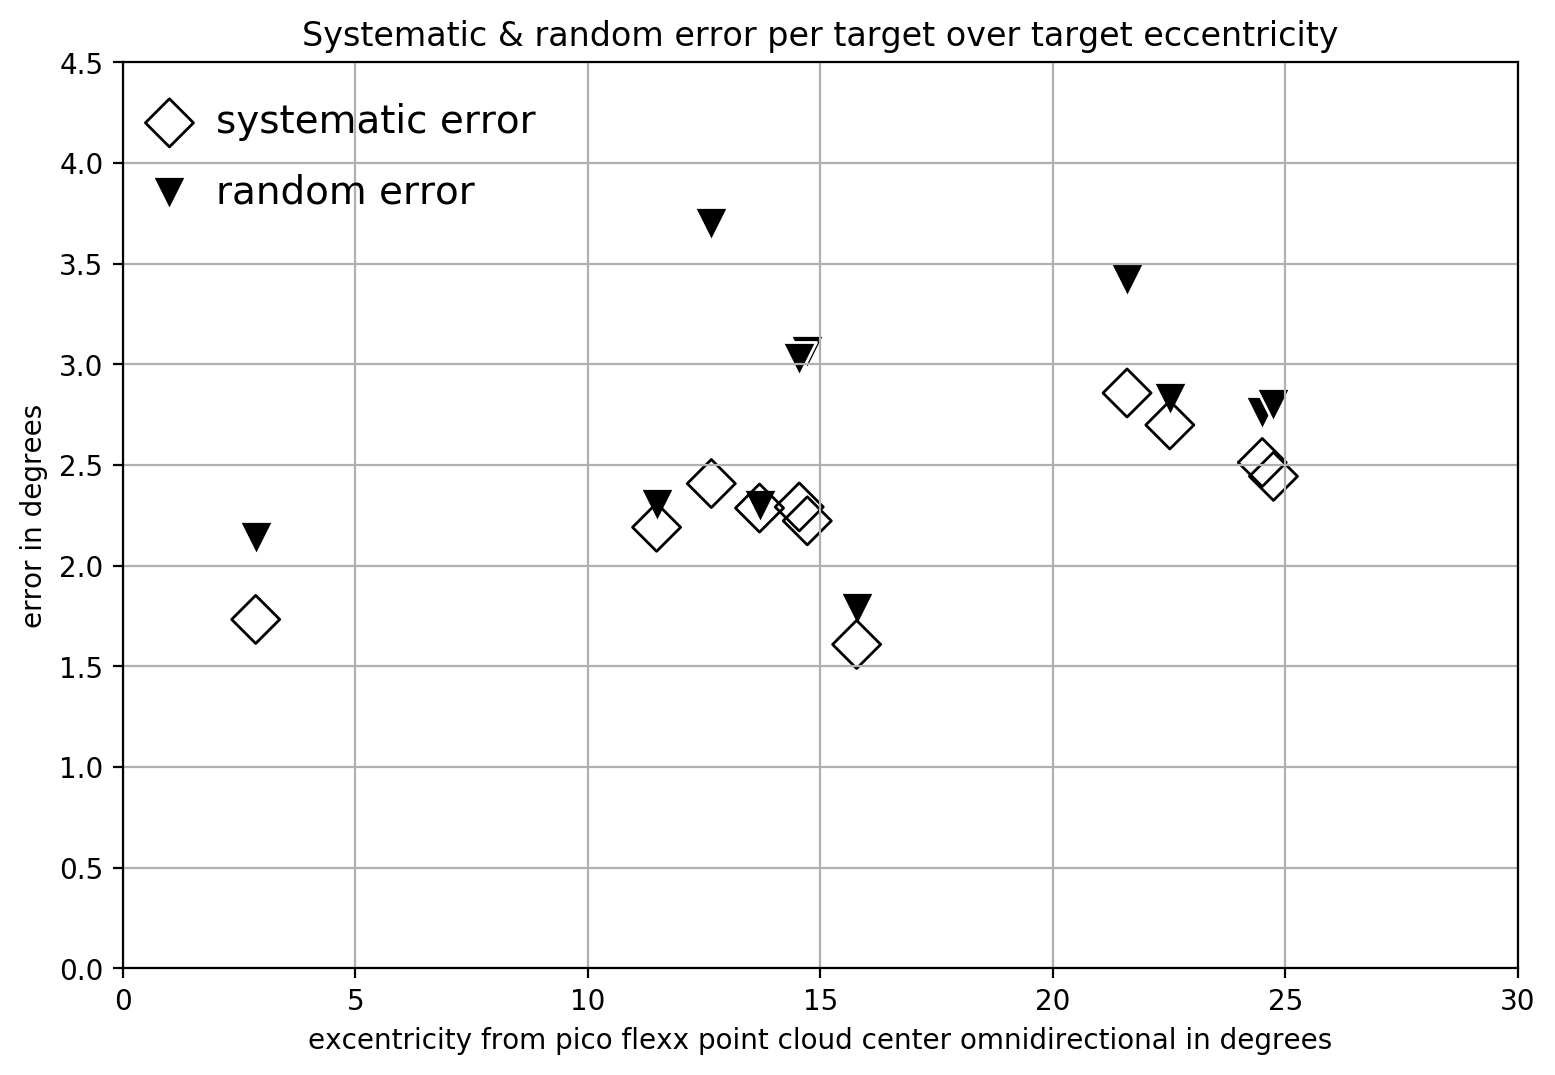

In [116]:
fig = plt.figure(3, figsize=(9,6), dpi=200, facecolor='w', edgecolor='k' )

plt.xlim([0, 30])
plt.ylim([0, 4.5])
plt.grid()

for t_aimed in range(1,12):
    x = MAE.loc[(MAE.t_id == t_aimed), 'x']
    y = MAE.loc[(MAE.t_id == t_aimed), 'y']
    plt.scatter(np.mean(x), np.mean(y), marker='v', c='k' , edgecolor = 'w', s=150)
    
    x_re = MAE.loc[(MAE.t_id == t_aimed), 'delta_mean_cc_x'] - np.mean(MAE.loc[(MAE.t_id == t_aimed), 'delta_mean_cc_x'])
    y_re = MAE.loc[(MAE.t_id == t_aimed), 'delta_mean_cc_y'] - np.mean(MAE.loc[(MAE.t_id == t_aimed), 'delta_mean_cc_y'])
    total_re = np.mean((x_re**2 + y_re**2)**.5  *.26)
    plt.scatter(np.mean(x), (total_re), marker='D', c='none', edgecolors = 'k', s=150)
    
plt.title('Systematic & random error per target over target eccentricity')
plt.ylabel('error in degrees')
plt.xlabel('excentricity from pico flexx point cloud center omnidirectional in degrees')
# legend 
plt.scatter(1, 4.2, marker='D', c='none', edgecolors = 'k', s=150) 
plt.text(2, 4.15, 'systematic error', fontsize=14)
plt.scatter(1, 3.85,  marker='v', c='k' , edgecolor = 'w', s=150) 
plt.text(2, 3.8, 'random error', fontsize=14)


output_fn = os.path.join(r'C:\Users\p.wagner\Documents\phd\output', 
                         'SE_RE_excentricity.jpeg')

plt.savefig(output_fn, orientation='landscape')
plt.show()